# Dataset Exploration and Preprocessing

In this notebook we perform an Exporatory Data Analysis of the Kaggle Sticker Sales Dataset. The main purpose of this notebook is to provide relevant insights on our data that will later guide our feature engineering and modelling strategies. We also perform some initial cleaning, such as getting rid of some columns and treating missing values.

In [ ]:
#Install the holidays library if necessary
#! pip install holidays

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import holidays
import numpy as np

## Initial Exploration

In [ ]:
# Load the DataFrame and perform an initial visualization. 
# Don't forget to modify the working directory if necessary

df = pd.read_csv("data/stickers/train.csv")
df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [ ]:
df.info() #Information about data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


- The id column doesen't provide useful information.
- We can transform the date column into pandas datetime format for easier processing.  Date can be treated as a temporal variable, allowing us to extract relevant information such as the day of the week, month, seasonality, or holidays.
- num_sold is the objective variable we eant to predict. Its Dtype (float) is correct.
- The rest of the columns: country, store and product seem to be categorical features.

In [29]:
df.drop(columns=["id"], inplace=True) # get rid of the id column
df["date"] = pd.to_datetime(df["date"]) # transform to appropriate datetime format

In summary, our feature vector is initially formed by the following variables: country, store, product and date. This are the available features to predict our objective variable y: num_sold.

In other words, our main goal is to forcast the total sales for a sticker product in a specific date, store and country.

## Categorical Variables

Next, we calculate the number of observations for the different "categories" of the variables country, store, and product.

In [ ]:
counts = df["country"].value_counts()
print(counts)
print()
plt.figure(figsize=(10,5))
counts.plot(kind='bar')
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Observations by country")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [ ]:
counts = df['product'].value_counts()
print(counts)
print()
plt.figure(figsize=(10,5))
counts.plot(kind='bar')
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Observations by product")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [ ]:
counts = df['store'].value_counts()
print(counts)
print()
plt.figure(figsize=(10,5))
counts.plot(kind='bar')
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Observations by store")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

Now, we are going to analyze the distribution of unique combinations of store, product, and country. 
 - First, we count how many times each combination appears in the dataset. 
 - Then, we retrieve the unique frequency values to understand the variability    in occurrence counts.

In [ ]:
# Frequency of unique combinations of store, product, and country
df[["store","product","country"]].value_counts()

store              product             country  
Discount Stickers  Holographic Goose   Canada       2557
Stickers for Less  Kaggle              Finland      2557
                   Holographic Goose   Singapore    2557
                                       Norway       2557
                                       Kenya        2557
                                                    ... 
Discount Stickers  Kerneler Dark Mode  Norway       2557
                                       Kenya        2557
                                       Italy        2557
                                       Finland      2557
Stickers for Less  Kerneler Dark Mode  Singapore    2557
Name: count, Length: 90, dtype: int64

In [ ]:
# Unique frequency values of store, product, and country combinations
df[["store","product","country"]].value_counts().unique()

array([2557], dtype=int64)

Note that we have the same amount of samples for each combination of store, product and country. We have no more than 6 possible values for each category.

## Missing Values

In [35]:
df.isna().sum()/len(df)

date        0.000000
country     0.000000
store       0.000000
product     0.000000
num_sold    0.038548
dtype: float64

Approximately 3% of the data is missing in the target variable num_sold.
No missing values are present in the explanatory variables.

In [ ]:
# Identify rows where the target variable 'num_sold' is missing
df_nulos = df[df['num_sold'].isnull()]

# Display the unique dates where 'num_sold' is null
print(df_nulos['date'].unique())
print()

# Initial assumption: Missing values might be related to holidays when stores are closed
df_nulos['day_of_year'] = pd.to_datetime(df_nulos['date']).dt.strftime('%d-%m')
print(df_nulos['day_of_year'].unique())

The assumption was incorrect, as there is no clear correlation with holidays.

In [36]:
df[df["num_sold"].isna()].groupby(["store", "country", "product"]).size()

store                 country  product           
Discount Stickers     Canada   Holographic Goose     2557
                               Kerneler                 1
                      Kenya    Holographic Goose     2557
                               Kerneler                63
                               Kerneler Dark Mode       1
Premium Sticker Mart  Canada   Holographic Goose      380
                      Kenya    Holographic Goose      646
Stickers for Less     Canada   Holographic Goose     1308
                      Kenya    Holographic Goose     1358
dtype: int64

 - Missing values are highly concentrated in the Holographic Goose product.
 - They occur mostly in Canada and Kenya.
 - This suggests that the missing data is Not Missing At Random.

C:\Users\rjvil\AppData\Local\Temp\ipykernel_28216\514793336.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["is_na"]=df_nan["num_sold"].isna()


Text(0.5, 0.98, 'Missing Values Patterns in Kenya and Canada for Holographic Goose')

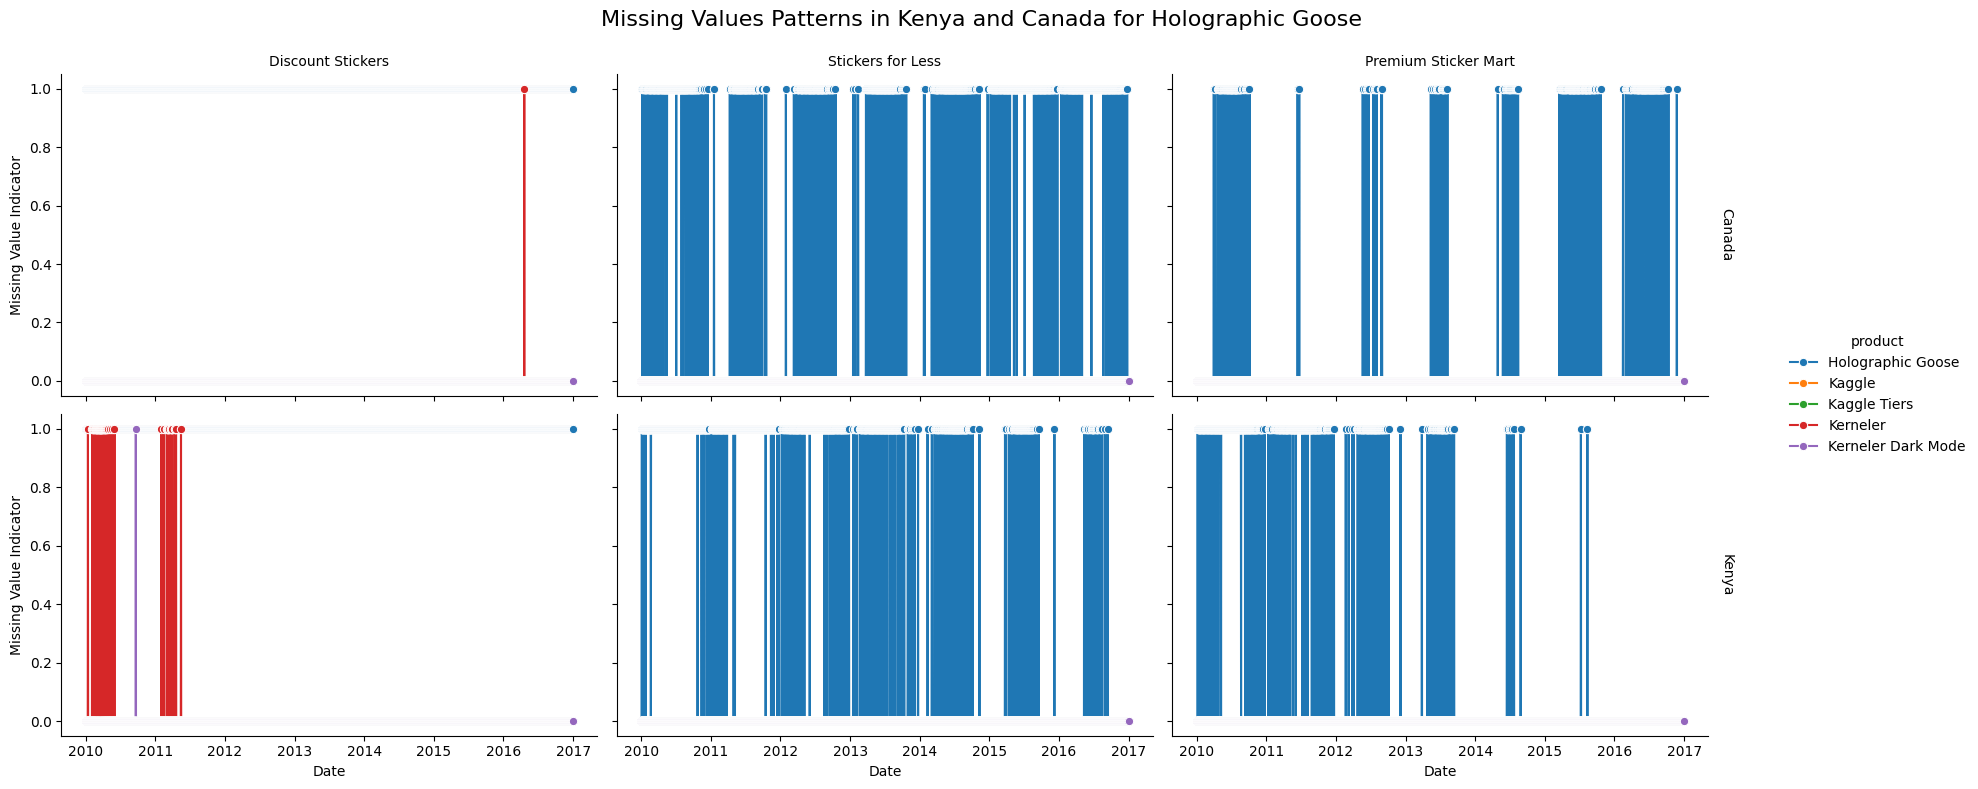

In [ ]:
# Focusing on Canada, Kenya and Holographic Goose for further analysis
df_nan=df[df["country"].isin(["Canada","Kenya"])]
df_nan["is_na"]=df_nan["num_sold"].isna()

g = sns.FacetGrid(df_nan, row="country", col="store", hue="product", margin_titles=True, height=4, aspect=1.5)
g.map(sns.lineplot, "date", "is_na", marker="o")
g.add_legend()
g.set_axis_labels("Date", "Missing Value Indicator")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Missing Values Patterns in Kenya and Canada for Holographic Goose', fontsize=16)

We decide to drop missing values, as we cannot make up new entire series, there are a huge amount of values to impute. Given the extent and concentration of missing values in specific stores/products, imputing entire sales series could be challenging and may introduce bias. Therefore, dropping these missing values seems like a reasonable approach in this case.

In [38]:
df.dropna(inplace=True)

## Checking Ouliers

<Axes: >

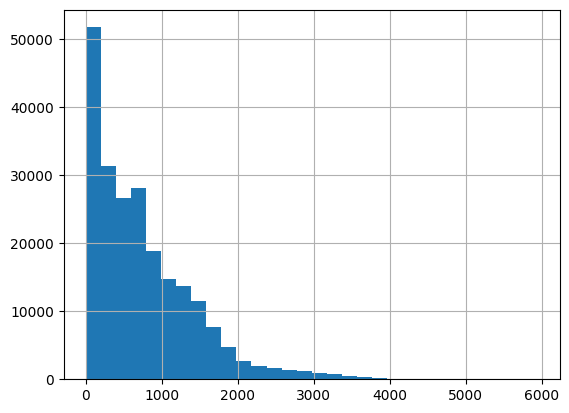

In [ ]:
#Distribution of the target variable
df["num_sold"].hist(bins=30)

<Axes: ylabel='num_sold'>

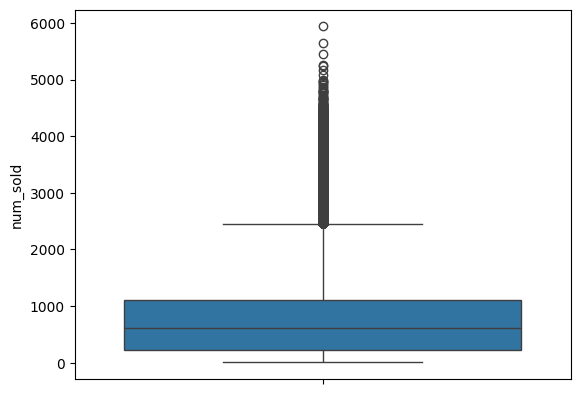

In [ ]:
sns.boxplot(df["num_sold"]) 

In [ ]:
#Tukey's rule:: the distribution of the target is not symmetric

Q1 = df['num_sold'].quantile(0.1) # change the quantiles for making it more or less strict, normally it should be 0.25 and 0.75
Q3 = df['num_sold'].quantile(0.9)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['num_sold'] < lower_bound) | (df['num_sold'] > upper_bound)]

outliers

,date,country,store,product,num_sold
251,2010-01-03,Norway,Premium Sticker Mart,Kaggle,4541.0
9071,2010-04-11,Norway,Premium Sticker Mart,Kaggle,4096.0
32651,2010-12-29,Norway,Premium Sticker Mart,Kaggle,4134.0
32831,2010-12-31,Norway,Premium Sticker Mart,Kaggle,4364.0
32921,2011-01-01,Norway,Premium Sticker Mart,Kaggle,4439.0
...,...,...,...,...,...
164046,2014-12-28,Norway,Stickers for Less,Kaggle,4444.0
164051,2014-12-28,Norway,Premium Sticker Mart,Kaggle,5643.0
164141,2014-12-29,Norway,Premium Sticker Mart,Kaggle,4402.0
164231,2014-12-30,Norway,Premium Sticker Mart,Kaggle,4538.0


We do not consider this values as anormally high.
Most of them are in Christmas, which may mean this values are just high sale numbers do to christmas holiday and presents.

## Target Variable

It is important to take into account that our data follows different time series. There is a possibility that sales depend on previous values and other temporal factors.

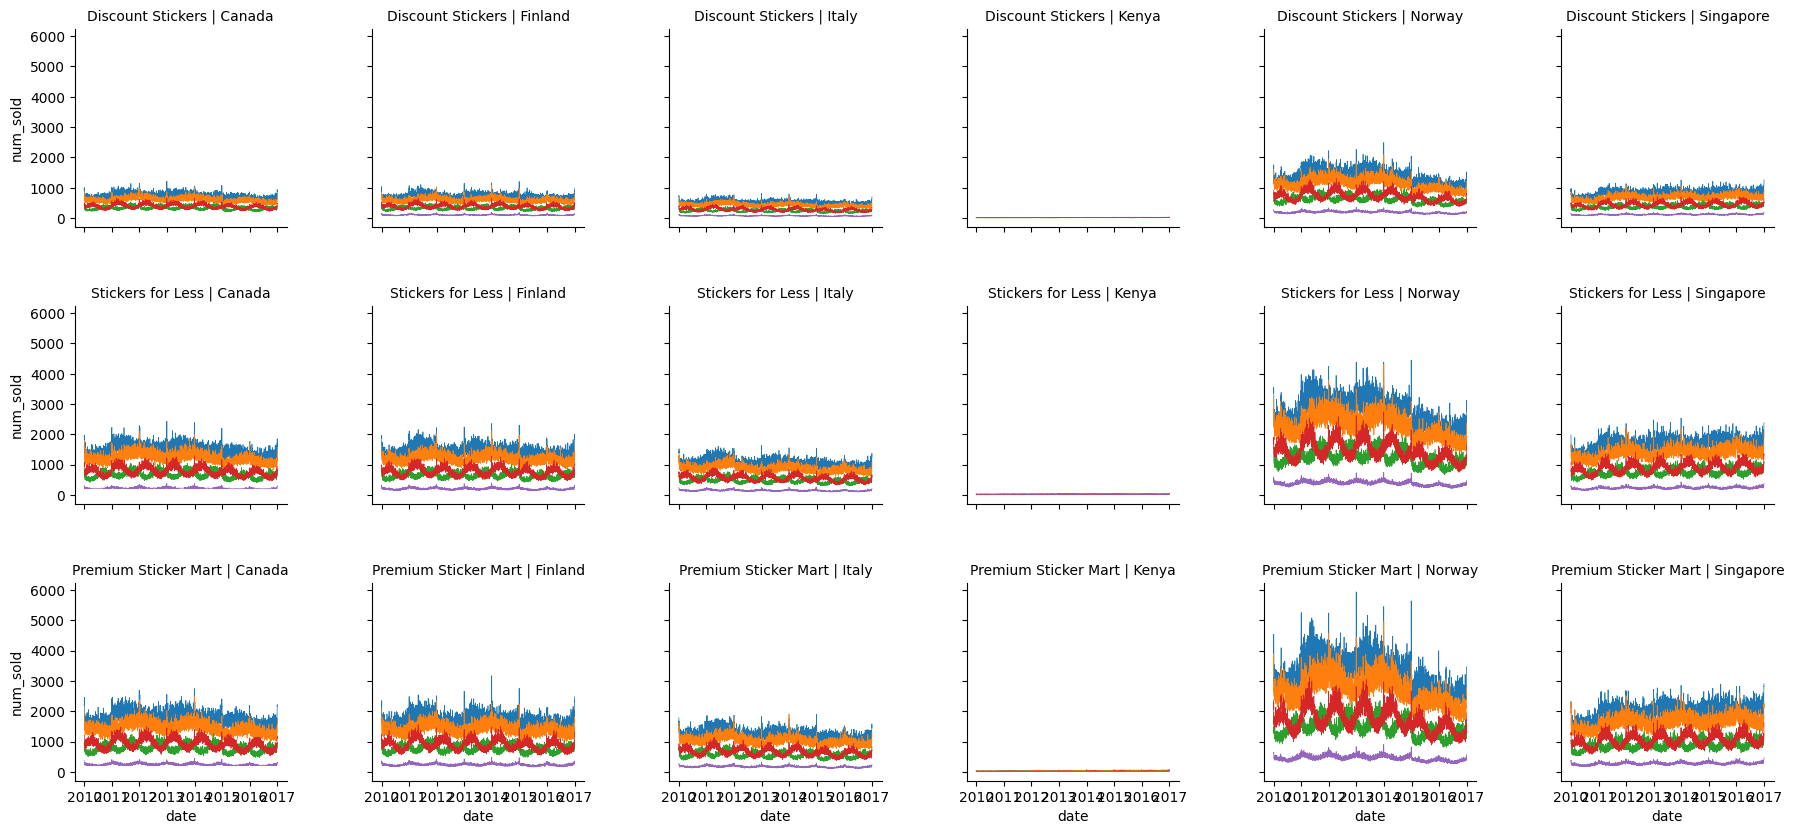

In [42]:
g = sns.FacetGrid(df, col="country", row="store", hue="product")
g.map(sns.lineplot, "date", "num_sold", linewidth=0.5)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=10)
plt.subplots_adjust(top=0.9, hspace=0.4, wspace=0.4)

- Kenya has very low sales while Norway has higher number of sales.
- The rest of the 3 countries present very similar behaviours.
- There are visible trends and seasonal component (cycles that repeat every year)

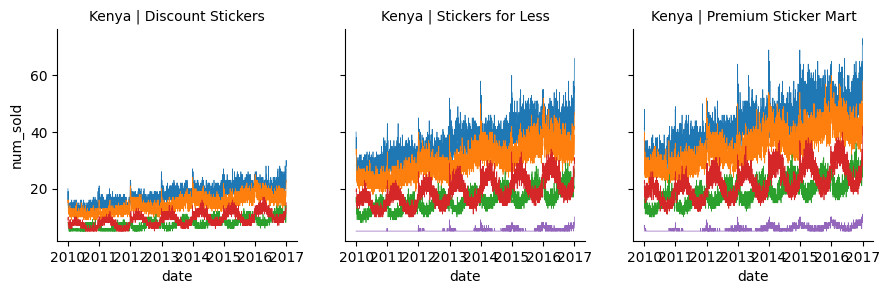

In [66]:
# visualizar kenya aparte
g = sns.FacetGrid(df[df["country"]=="Kenya"], col="store", row="country", hue="product")
g.map(sns.lineplot, "date", "num_sold", linewidth=0.5)
g.set_titles(col_template="{col_name}", row_template="{row_name}", size=10)
plt.subplots_adjust(top=0.9, hspace=0.2, wspace=0.2)

## Date-related Features
There are hidden patterns within the date that may influence shopping trends such as the day of the week, holidays, current season... In this section we briefly analyze if there is a visible relation between sticker sales and date-related features.

In [ ]:
# We map seasons and days of the week for better interpretability.
# Additionally, we determine whether a given date is a holiday based on the country.

# Define mappings for seasons and days of the week

season_map = {
    1: "Winter",
    2: "Spring",
    3: "Summer",
    4: "Autumn"
}

day_of_week_map = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

def is_holiday(row):
    country = row["country"]
    date = row["date"]
    
    # Country codes for holiday lookup
    country_codes = {
        "Canada":"CA",
        "Finland":"FI",
        "Norway":"NO",
        "Kenya":"KE",
        "Italy":"IT",
        "Singapore":"SG",
    }
    return 1 if date in holidays.country_holidays(country_codes.get(country)) else 0

df["month"] = df["date"].dt.month

df["season"] = (df["month"]%12 + 3)//3
df["season"] = df["season"].map(season_map)

df["year"] = df["date"].dt.year
df["day of week"] = df["date"].dt.dayofweek

df["day of week"] = df["day of week"].map(day_of_week_map)

df["holiday"] = df.apply(lambda row: is_holiday(row), axis=1)
df["day"] = df["date"].dt.day

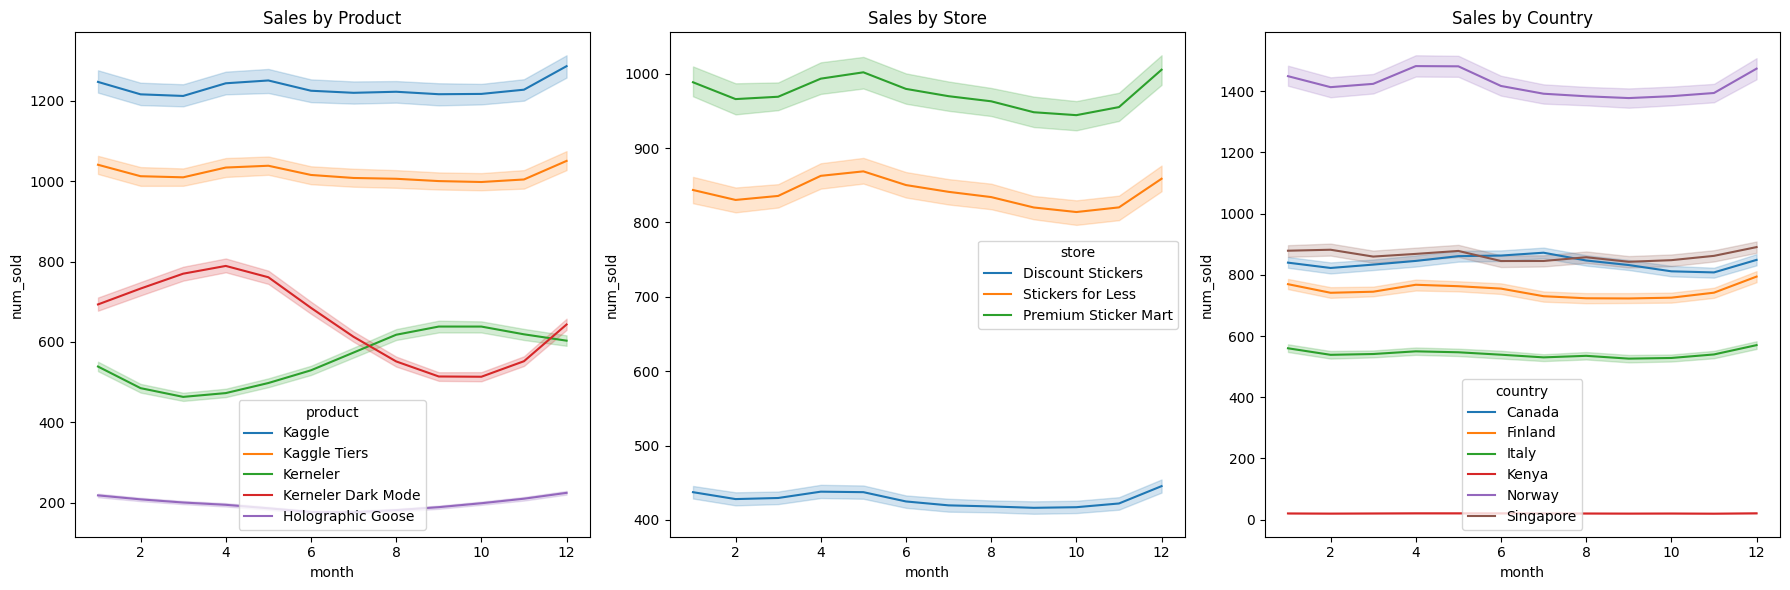

In [ ]:
# Visualizing sales trends across different dimensions.
# We create line plots to observe how sales fluctuate over the months for various products, stores, and countries.

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.lineplot(data=df, x="month", y="num_sold", hue="product", ax=axes[0])
axes[0].set_title('Sales by Product')

sns.lineplot(data=df, x="month", y="num_sold", hue="store", ax=axes[1])
axes[1].set_title('Sales by Store')

sns.lineplot(data=df, x="month", y="num_sold", hue="country", ax=axes[2])
axes[2].set_title('Sales by Country')

plt.tight_layout()
plt.show()

At the end of the year there is a spike in sales, probably due to Christmas holidays and presents. It is also interesting that there is a time in the year in which Kerneler sales go up while Kerneler Dark Mode sales decrease, this migth be an indicator that there might be cannibalism among products. This topic will be covered in Notebook 2 in more detail.

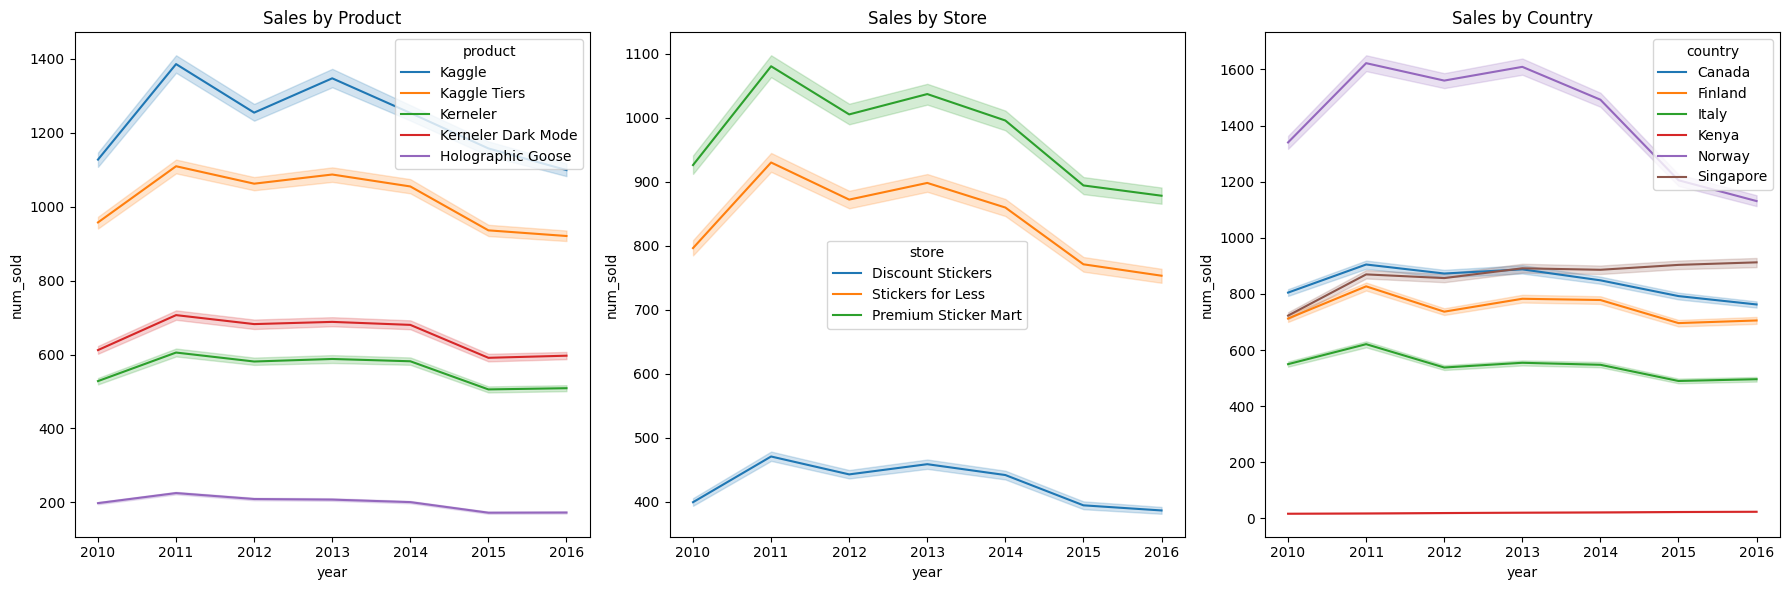

In [ ]:
# Sales trends over the years

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.lineplot(data=df, x="year", y="num_sold", hue="product", ax=axes[0])
axes[0].set_title('Sales by Product')

sns.lineplot(data=df, x="year", y="num_sold", hue="store", ax=axes[1])
axes[1].set_title('Sales by Store')

sns.lineplot(data=df, x="year", y="num_sold", hue="country", ax=axes[2])
axes[2].set_title('Sales by Country')

plt.tight_layout()
plt.show()

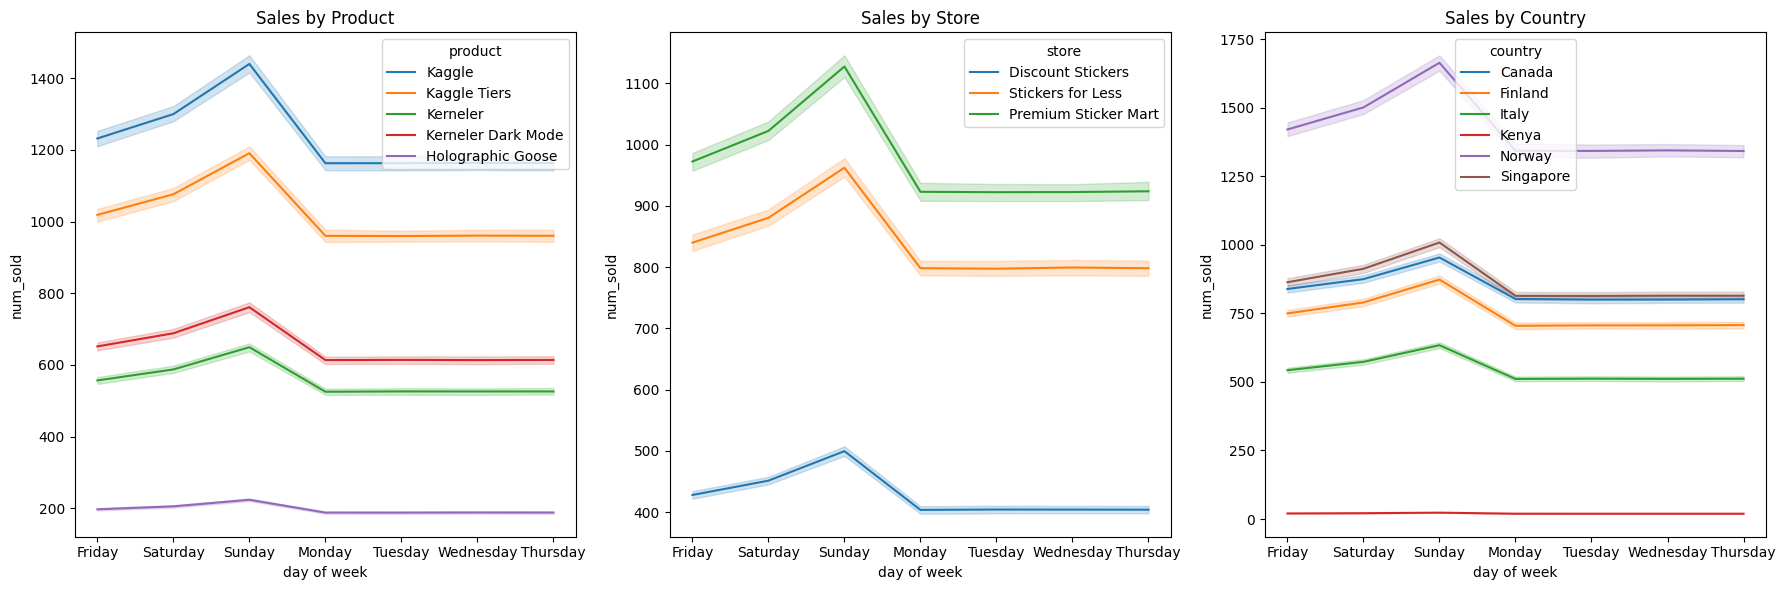

In [ ]:
# Sales trends over the days of the week

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.lineplot(data=df, x="day of week", y="num_sold", hue="product", ax=axes[0])
axes[0].set_title('Sales by Product')

sns.lineplot(data=df, x="day of week", y="num_sold", hue="store", ax=axes[1])
axes[1].set_title('Sales by Store')

sns.lineplot(data=df, x="day of week", y="num_sold", hue="country", ax=axes[2])
axes[2].set_title('Sales by Country')

plt.tight_layout()
plt.show()

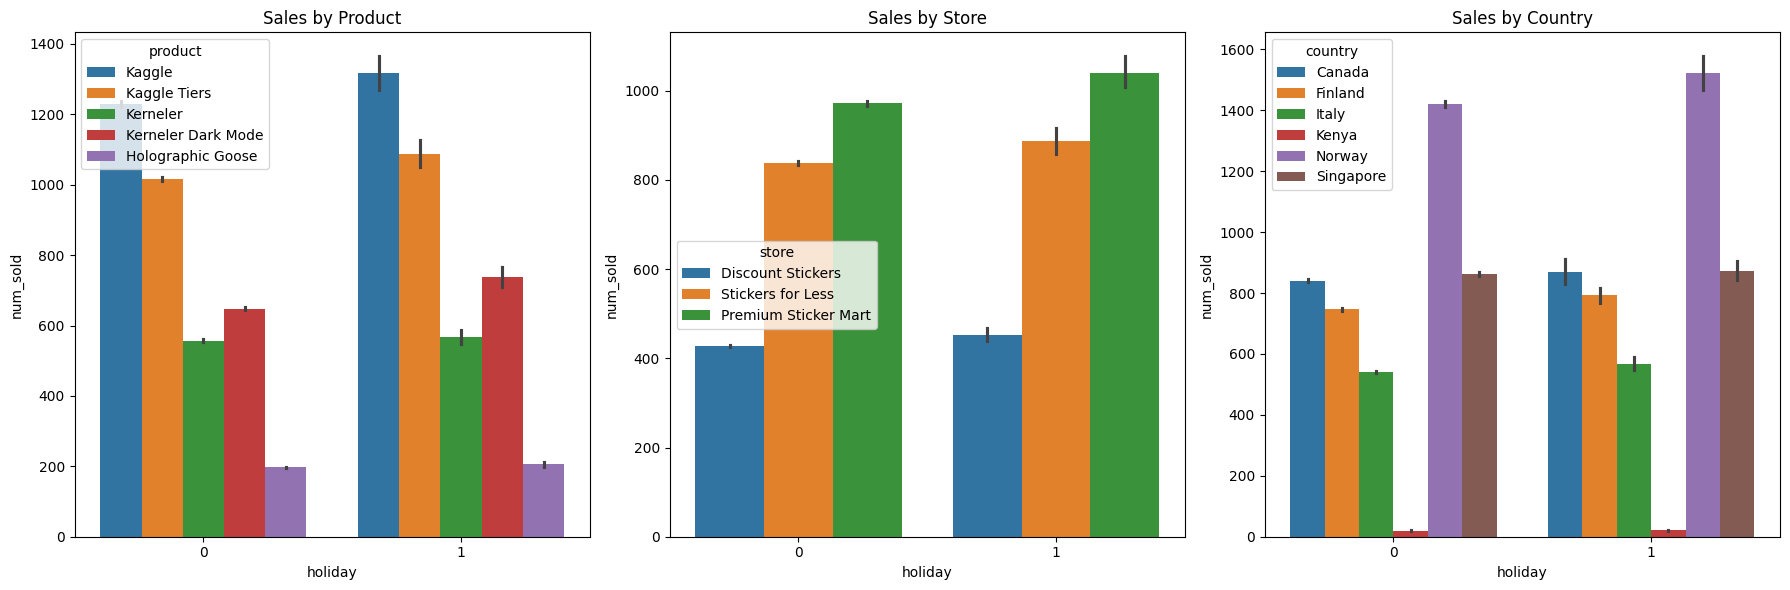

In [ ]:
# Sales impact on holidays

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=df, x="holiday", y="num_sold", hue="product", ax=axes[0])
axes[0].set_title('Sales by Product')

sns.barplot(data=df, x="holiday", y="num_sold", hue="store", ax=axes[1])
axes[1].set_title('Sales by Store')

sns.barplot(data=df, x="holiday", y="num_sold", hue="country", ax=axes[2])
axes[2].set_title('Sales by Country')

plt.tight_layout()
plt.show()

It looks like sales increase a little bit during holidays but no that much.

## Correlation analysis

Checking if there is a visible correlation between sales and date features. 

In [62]:
df_numeric = df.select_dtypes(include=["float64", "int64","int"])
df_numeric.corr().style.background_gradient(cmap='coolwarm')

,num_sold,month,year,day of week,weekend,holiday,day
num_sold,1.000000,-0.006255,-0.040462,0.069613,0.072310,0.011670,0.001137
month,-0.006255,1.000000,-0.001142,-0.003621,-0.003502,-0.003506,0.011878
year,-0.040462,-0.001142,1.000000,-0.000602,-0.001108,-0.001631,0.000507
day of week,0.069613,-0.003621,-0.000602,1.000000,0.791404,0.009206,0.001734
weekend,0.072310,-0.003502,-0.001108,0.791404,1.000000,0.004016,0.002515
holiday,0.011670,-0.003506,-0.001631,0.009206,0.004016,1.000000,-0.052431
day,0.001137,0.011878,0.000507,0.001734,0.002515,-0.052431,1.000000


The correlation matrix does not reveal a strong linear relationship between num_sold and the date features. Instead, these features often exhibit cyclical or categorical patterns. To capture this, we should consider more sophisticated feature engineering techniques and analyze residuals to uncover more complex interactions (e.g., weekends near holidays). These analysis will be detailed in Notebook 2.